### Generalized Lifespan Inference
Aaron R. Voelker (January 25, 2017)

The lifespan problem from Griffiths and Tenenbaum (2006) is generalized as follows:
- $X = \{x_1, \ldots, x_N \}$ is a set of $N$ random variables, corresponding to the observed ages of $N$ people. Each $x_i$ is a single $t$ from Tenenbaum's paper.
- $Z = \{z_1, \ldots, z_N \}$ is a set of $N$ random variables, corresponding to the hidden (unobserved) lifespan of the same $N$ people. Each $z_i$ is in a one-to-one corerspondance with its respective $x_i$, and is a single $t_{total}$ from Tenenbaum's paper.
- $\alpha = (\mu, \sigma)$ are the underlying hyperparameters from which each $z_i$ is drawn. In particular we model $z_i|\alpha \sim \mathcal{N}(\mu, \sigma^2)$.
- Each $x_i$ is drawn conditionally from $z_i$. In particular we model $x_i|z_i \sim \mathcal{U}[0, z_i)$, meaning that we are equally likely to see a person at any time throughout their life.
- We assume mutual independence between all $N$ people.

This is summarized in <a href="https://en.wikipedia.org/wiki/Plate_notation">Plate notation</a> as follows:
![](http://i.imgur.com/gmLKIjJ.png)

which can be understood as a two-stage hierarchical Bayes model.

The data is generated in the forward direction ($\alpha \longrightarrow Z \longrightarrow X$). Then only $X$ is accessible to the model, along with the "knowledge" of how this was generated. The actual parameters for $Z$ and $\alpha$ are hidden from the model. The task is then to infer the most likely $Z$ and $\alpha$ given the observed sample $X$.

In theory this should be done by solving:
$$\hat{\alpha} = \text{argmax}_{\alpha} L(\alpha; X) = \text{argmax}_{\alpha} \sum_{Z} p(X, Z | \alpha)$$
to get an optimal estimate of the hyperparameters. This essentially means trying every possible $\alpha$ and $Z$ and seeing which one most likely explains the observed data. Note that once the hyperparameters are known, it is also straightforward to estimate $\hat{Z}$ using some Bayesian estimator, and using the prior $P(Z | \hat{\alpha})$ (this is what Tenenbaum does by pretending they already know the optimal prior).

However, this notebook will show that this ideal iteration over all ($\alpha$, $Z$) is untractable in general, and what to do to make it tractable (e.g., Expectation-Maximization).

In [ ]:
%pylab inline
import pylab
import seaborn as sns
sns.set_context("talk")

import numpy as np


In [111]:
M = 150    # maximum age
N = 1000   # number of independent samples
K = 200    # resolution of PDFs

# Start by computing the hidden (unobserved) parameters
# using some hyperparameters alpha = (mu, std).
# Neither of these will be accessible because that is what we're
# trying to figure out! However the knowledge of how the hyperparameters
# generated the hidden parameters will become a part of the model.
mu_ANSWER = 75
std_ANSWER = 16
Z_ANSWER = std_ANSWER * np.random.randn(N) + mu_ANSWER

# From these, draw the input (observed) parameters x_i ~ U[0, z_i]
# which WILL be accessible to the code / etc. 
# "we are equally likely to meet a man at any point in his life"
# and the model will again make use of this knowledge.
X = np.asarray([np.random.uniform(high=th) for th in Z_ANSWER])
assert (0 <= X).all() and (X <= M).all()

# So far we have generated the sample data in the forward direction
# (alpha -> Z -> X). Now the inference problem is essentially the reverse
# direction (X -> (Z, alpha)) using knowledge of these distributions.

In [ ]:
pylab.figure()
pylab.title("Sampled Data")
sns.kdeplot(X, label=r"Observed Ages $X$ (Input)")
sns.kdeplot(Z_ANSWER, label=r"Unobserved Lifespans $Z$ (Hidden)")
sns.kdeplot(Z_ANSWER - X, label=r"Remaining Life $Z - X$", linestyle='--')
pylab.xlim(0, M)
pylab.xlabel("Age")
pylab.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pylab.show()

# Note that X has the same distribution as Z - X.
# This is not a coincidence. It has to do with way in which X was generated;
# in particular z_i - x_i ~ U[0, z_i].

In [ ]:
# Now we want to recover Z (and alpha) from X.
# But even though X has the same distribution as Z - X
# that does NOT mean X = Z - X <=> Z = 2*X
# Equality of distributions does not imply equality of samples!

pylab.figure()
pylab.title("An Incorrect Naive Approach")
sns.kdeplot(2*X, label=r"$2X$")
sns.kdeplot(Z_ANSWER, label=r"Unobserved Lifespans $Z$ (Hidden)")
pylab.xlim(0, M)
pylab.xlabel("Age")
pylab.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pylab.show()

# The fact that the distributions are the same, however, does give
# hope that it should be possible to recover the distribution of the
# (unobserved) hidden variables.

We now define the model prior $p(z_i)$ -- using the Normal distribution with some given parameters -- and the likelihood $p(x_i | z_i)$ -- as defined in the Tenenbaum paper. Note that we drop the dependence on $\alpha$ here in the notation (for cleanliness), since it will be fixed.

In [112]:
axis = np.linspace(0, M, K)

def normal(mu, std):
    return np.exp(-(axis - mu)**2 / (2*std**2)) / np.sqrt(2*std**2*np.pi)

def uniform_posterior(x_i):
    l = np.zeros_like(axis)
    l[axis > x_i] = 1. / axis[axis > x_i]
    return l

likelihood = np.empty((N, K))
for i, x_i in enumerate(X):
    likelihood[i, :] = uniform_posterior(x_i)
    
print("Likelihood has %d million elements" % (likelihood.size // 1000000))

Likelihood has 0 million elements


Tenenbaum's approach deals with each sample in isolation, and simply applies Bayes rule:

$$p(z_i|x_i) \propto p(z_i,x_i) = p(x_i|z_i) p(z_i)$$

(where proportionality is with respect to constant $p(x_i)$) since we have the knowledge that

$$x_i|z_i \sim U[0, z_i] .$$

Then we apply some Bayesian estimator to $p(z_i|x_i)$ to determine the most likely $z_i$. In the paper they suggest using the median. If we have the correct prior $p(z_i)$ (i.e., the _true_ $\alpha$), then **this is optimal** with respect to the chosen Bayesian estimator.

In [ ]:
mu = mu_ANSWER    # <-- cheating!
std = std_ANSWER  # <-- cheating!
prior = normal(mu, std)

Z_median = np.empty_like(X)
#Z_map = np.empty_like(X)
for i in range(N):
    joint = likelihood[i] * prior  # proportional to posterior
    cpdf = np.cumsum(joint)
    Z_median[i] = axis[np.where(cpdf >= (cpdf[-1] / 2))[0][0]]  # Median estimate
    #Z_map[i] = axis[np.argmax(joint)]  # MAP estimate

# Here we graph the difference in the true Z versus the estimate Z
# for the median estimator. And then we can compare this to using
# 2*X as a naive estimator, which is worse. We can also always guess
# mu, which is almost as good (surprisingly, since it does not even 
# depend on X). But the optimal estimate is still more sharply peaked.

def measure(r):
    return r"($%d \pm %d$)" % (np.mean(r), np.std(r))

pylab.figure()
pylab.title("Estimate Errors")
sns.kdeplot(Z_median - Z_ANSWER, label=r"Median %s" % measure(Z_median - Z_ANSWER))
#sns.kdeplot(Z_map - Z_ANSWER, label=r"MAP %s" % measure(Z_map - Z_ANSWER))
sns.kdeplot(mu - Z_ANSWER, label=r"$\mu$ %s" % measure(mu - Z_ANSWER))
sns.kdeplot(2*X - Z_ANSWER, label=r"$2X$ %s" % measure(2*X - Z_ANSWER))
pylab.xlabel(r"$\hat{Z} - Z$")
pylab.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pylab.show()

If we don't know the actual prior, then the **optimal solution** is to essentially "try them all". That is, find the hyperparameters $\alpha$ that maximize the marginal likelihood of the observed data, $L(\alpha; X)$ (or equivalently the log-likelihood for numerical stability).

$$
\begin{align}
&& L(\alpha; X) &= p(X | \alpha) \\
&& &= \prod_{i=1}^N p(x_i | \alpha) \\
&& &= \prod_{i=1}^N \sum_{z_i} p(x_i, z_i | \alpha) \\
&& \implies \quad \text{argmax}_\alpha L(\alpha; X) &= \text{argmax}_\alpha \log L(\alpha; X) \\
&& &= \text{argmax}_\alpha \sum_{i=1}^N \log \sum_{z_i} p(x_i, z_i | \alpha)
\end{align}
$$

In [114]:
max_L = float('-inf')
best_alpha = None

for mu in np.linspace(70, 80, 5):
    for std in np.linspace(10, 22, 3):
        prior = normal(mu, std)
 
        L = 0  # log-likelihood
        for i in range(N):
            L += np.log(np.dot(likelihood[i], prior))
        
        if L > max_L:
            max_L = L
            best_alpha = (mu, std)
            
        print(mu, std, L)
        
print("Optimal hyperparameters:", best_alpha)
print("Actual hyperparameters:", (mu_ANSWER, std_ANSWER))

(70.0, 10.0, -4250.6228505263398)
(70.0, 16.0, -4197.0206869971626)
(70.0, 22.0, -4197.7287088073954)
(72.5, 10.0, -4229.9618824273639)
(72.5, 16.0, -4191.30706504911)
(72.5, 22.0, -4195.6758867431763)
(75.0, 10.0, -4217.3351134683708)
(75.0, 16.0, -4189.9700327963901)
(75.0, 22.0, -4196.7425456804131)
(77.5, 10.0, -4211.582660786632)
(77.5, 16.0, -4192.5098947516453)
(77.5, 22.0, -4200.6412022193572)
(80.0, 10.0, -4211.6511610718417)
(80.0, 16.0, -4198.4554178240387)
(80.0, 22.0, -4207.1034116076171)
('Optimal hyperparameters:', (75.0, 16.0))
('Actual hyperparameters:', (75, 16))


---

But in general this procedure is intractable, since it requires that we iterate over an infinitely large parameter space for $\alpha$ (and sometimes also an infinitely large space for $Z$). This is why procedures like EM and EB exist: to make this tractable at the expense of suboptimality. But these solutions need to be worked out on a case-by-case basis depending on the model distributions.

Below we work this out for Expectation-Maximization, starting with a simplification of the expectation using independence and other known facts about the model:
$$
\begin{align}
Q(\alpha | \alpha^{(t)}) &= E_{Z|X,\alpha^{(t)}} \left[ \log L(\alpha; X, Z) \right] \\
&= \sum_{i=1}^N E_{z_i|x_i,\alpha^{(t)}} \left[ \log L(\alpha; x_i, z_i) \right] \\
&= \sum_{i=1}^N \sum_{z_i} p(z_i | x_i, \alpha^{(t)}) \log p(x_i, z_i | \alpha) \\
&= \sum_{i=1}^N \sum_{z_i} T(x_i, z_i) \log \left( p(x_i | z_i) p(z_i | \alpha) \right) \\
&= \sum_{i=1}^N \sum_{z_i} T(x_i, z_i) \log \left( p(z_i | \alpha) / z_i \right)
\end{align}
$$
where:
- $T(x_i, z_i) := p(z_i | x_i, \alpha^{(t)})$ is a fixed function with respect to $\alpha^{(t)}$
- $p(x_i, z_i | \alpha) = p(x_i | z_i) p(z_i | \alpha)$ is the same formula from Tenenbaum's paper, with $\alpha^{(t)}$ included, since $p(x_i | z_i, \alpha) = p(x_i | z_i)$ by assumption
- Substituting $p(x_i | z_i) = 1 / z_i$ for all $z_i$ is okay since $T(x_i, z_i) = 0$ for $z_i \le x_i$ by definition.

Next we simplify the log expression using knowledge of the prior, with unknown $\alpha = (\mu, \sigma)$:
$$
\begin{align}
\log \left( p(z_i | \alpha) / z_i \right) &= \log \left( \frac{1}{\sqrt{2\sigma^2 \pi}} e^{-\frac{(z_i - \mu)^2}{2\sigma^2}} \right) - \log z_i \\
&= -\frac{1}{2}(z_i - \mu)^2 / \sigma^2 - \frac{1}{2} \log \sigma^2 - \frac{1}{2} \log \left( 2\pi \right) - \log z_i \\
\end{align}
$$

We then differentiate this with respect to $\mu$:
$$
\begin{align}
\frac{\partial \log \left( p(z_i | \alpha) / z_i \right)}{\partial \mu} &= (z_i - \mu)\sigma^2
\end{align}
$$
and with respect to $\sigma^2$:
$$
\begin{align}
\frac{\partial \log \left( p(z_i | \alpha) / z_i \right)}{\partial \sigma^2} &= \frac{1}{2}(z_i - \mu)^2/\sigma^4 - \frac{1}{2}/\sigma^2 = \frac{1}{2}\left((z_i - \mu)^2 - \sigma^2 \right)/\sigma^4
\end{align}
$$

From linearity of differentation, we then know that the derivations of the $Q$ function are zero when:
$$
\frac{\partial Q(\alpha | \alpha^{(t)})}{d \mu} = \sum_{i=1}^N \sum_{z_i} T(x_i, z_i) (z_i - \mu)\sigma^2 = 0
$$
$$
\iff \mu = \frac{\sum_{i=1}^N \sum_{z_i} z_i T(x_i, z_i)}{\sum_{i=1}^N \sum_{z_i} T(x_i, z_i)}
$$
and similarly:
$$
\frac{\partial Q(\alpha | \alpha^{(t)})}{d \sigma^2} = \sum_{i=1}^N \sum_{z_i} T(x_i, z_i) \frac{1}{2}\left((z_i - \mu)^2 - \sigma^2 \right)/\sigma^4 = 0
$$
$$
\iff \sigma^2 = \frac{\sum_{i=1}^N \sum_{z_i} (z_i - \mu)^2 T(x_i, z_i)}{\sum_{i=1}^N \sum_{z_i} T(x_i, z_i)}
$$

Next, by the generalized Bayes rule, we know:
$$
T(x_i, z_i) = p(z_i | x_i, \alpha^{(t)}) = \frac{p(z_i, x_i | \alpha^{(t)})}{ \sum_{z_i} p(z_i, x_i | \alpha^{(t)}) }
$$
which we already know how to compute (see the Tenenbaum solution).

We also note that since $T(\cdot)$ is a probability density function over $z_i$, that:
$$
\sum_{i=1}^N \sum_{z_i} T(x_i, z_i) = \sum_{i=1}^N 1 = N
$$

Therefore, each iteration should make the update $\alpha^{(t+1)} = (\mu^{(t+1)}, \sigma^{(t+1)})$, where:
$$
\begin{align}
\mu^{(t+1)} &= \frac{1}{N} \sum_{i=1}^N \frac{\sum_{z_i} z_i p(z_i, x_i | \alpha^{(t)})}{\sum_{z_i} p(z_i, x_i | \alpha^{(t)})} \\
\sigma^{(t+1)} &= \sqrt{\frac{1}{N}  \sum_{i=1}^N \frac{\sum_{z_i} (z_i - \mu^{(t+1)})^2 p(z_i, x_i | \alpha^{(t)})}{\sum_{z_i} p(z_i, x_i | \alpha^{(t)})}}
\end{align}
$$
which we implement as follows using matrices and dot products.

In [115]:
# Start with an initial guess for the hyperparameters
mu = 90
std = 5
num_steps = 100
alpha = np.empty((num_steps, 2))

# And then use estimates of Z to estimate the new prior
from nengo.utils.progress import ProgressTracker
with ProgressTracker(1, True, "Initializing"): pass  # Hack to fix bug
with ProgressTracker(2 * num_steps, True, "Expectation-Maximization") as progress:
    for k in range(num_steps):
        prior = normal(mu, std)

        def sum_over(g):
            #s = 0
            #for i in range(N):
            #    s += np.dot(g, likelihood[i] * prior) / np.dot(likelihood[i], prior)
            return np.sum(  # numpy optimized version of above comment
                np.dot(g, likelihood.T * prior[:, None]) /
                np.dot(likelihood, prior))

        mu = sum_over(axis) / N
        progress.step()
        std = np.sqrt(sum_over((axis - mu)**2) / N)
        progress.step()

        alpha[k, :] = [mu, std]

print("Final hyperparameters:", mu, std)

Initializing finished in 0:00:01.                                               
Expectation-Maximization finished in 0:00:01.                                   
('Final hyperparameters:', 74.197123204160462, 16.945475056503032)


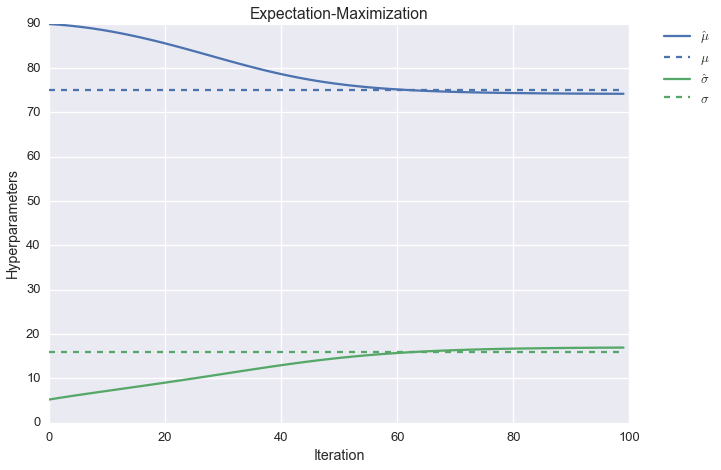

In [116]:
cpal = sns.color_palette(None, 2)

pylab.figure()
pylab.title("Expectation-Maximization")
pylab.plot(range(num_steps), alpha[:, 0], c=cpal[0], label=r"$\hat{\mu}$")
pylab.plot(range(num_steps), mu_ANSWER * np.ones(num_steps), c=cpal[0], linestyle='--', label=r"$\mu$")
pylab.plot(range(num_steps), alpha[:, 1], c=cpal[1], label=r"$\hat{\sigma}$")
pylab.plot(range(num_steps), std_ANSWER * np.ones(num_steps), c=cpal[1], linestyle='--', label=r"$\sigma$")
pylab.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pylab.xlabel("Iteration")
pylab.ylabel("Hyperparameters")
pylab.show()

### Stepwise Expectation Maximization

(February 12, 2017)

Stepwise EM is unstable in the beginning (since we are using mini-batch size of 1). As we increase the size of mini-batch, it should become more stable (basic EM above is an example of extreme case where mini-batch has the maximum size i.e., equal to the full set of examples). 

In the implementation of Stepwise EM, the E and M step are performed alternately for each incoming example. Once all examples have arrived, further iterations can still be performed if required. Here we have 1000 examples, so the parameters are updated 1000 times as the examples arrive and then 10 more iterations are performed at the end once we have all the examples. Thus stepwise EM is run for 10 batch iterations (thought the total number of updates is 1000*10) whereas basic EM is run for 100 batch iterations (and total number of updates is 100).

Reference: http://cs.stanford.edu/~pliang/papers/online-naacl2009.pdf


In [147]:
## Stepwise EM - Correction, closed form
## Iterating once all the samples have come

# Start with an initial guess for the hyperparameters
mu = 90
std = 5
num_steps = 10 #100
alpha = np.empty((num_steps, N, 2))

mu_S = 0   # sufficient statistics
std_S = 0  # sufficient statistics

k = 0        # number of updates made to S so far
m = 1        # mini batch size 

beta = 0.84  # should be between 0.5 to 1, higher value means 
             # more weight is given to the previous set of 
             # examples  relative to one incoming example

# And then use estimates of Z to estimate the new prior
from nengo.utils.progress import ProgressTracker
with ProgressTracker(1, True, "Initializing"): pass  # Hack to fix bug
with ProgressTracker(2 * num_steps, True, "Expectation-Maximization") as progress:
    
    # for each observed example
    for j in range(num_steps):    

        # iterate a couple times
        x = range(N)
        #random.shuffle(x)
        for i in x:
            prior = normal(mu, std)

            
            def sum_over(g): 
                # only sum over the examples in the mini-batch
                # but in our case m = 1, so no summing over is required
                # this code is not setup for m>1
                s = 0
                s += np.dot(g, likelihood[i] * prior) / np.dot(likelihood[i], prior)
                return s
            
            
            mu_sbar = sum_over(axis) / m
            progress.step()
            
            
            gamma = np.power(float(k+2), -beta)  # learning rate
            k = k + 1
            
            mu_S = gamma*mu_sbar + (1-gamma)*mu_S
            
            
            std_sbar = np.sqrt(sum_over((axis - mu_S)**2) / m)
            progress.step()
            std_S = gamma*std_sbar + (1-gamma)*std_S

            mu = mu_S
            std = std_S
            alpha[j, i, :] = [mu, std]
        
                    
print("Final hyperparameters:", mu, std)


Initializing finished in 0:00:01.                                               
Expectation-Maximization finished in 0:00:01.                                   
('Final hyperparameters:', 74.00901921888078, 15.184909804037254)


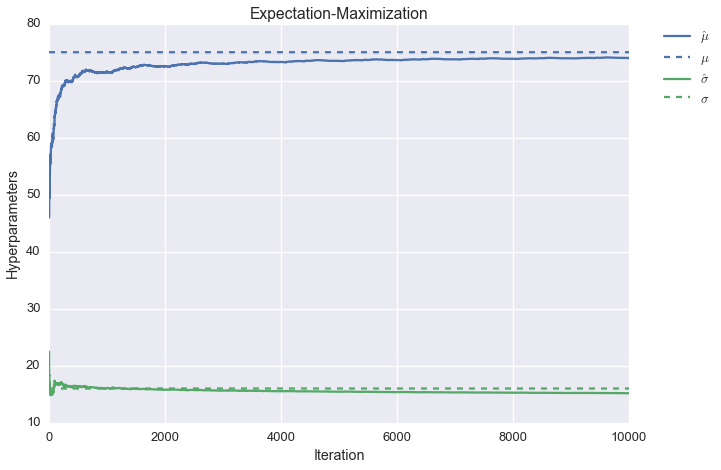

In [148]:
cpal = sns.color_palette(None, 2)

pylab.figure()
pylab.title("Expectation-Maximization")
pylab.plot(range(N*num_steps), alpha[:, :, 0].flatten(), c=cpal[0], label=r"$\hat{\mu}$")
pylab.plot(range(N*num_steps), mu_ANSWER * np.ones(N*num_steps), c=cpal[0], linestyle='--', label=r"$\mu$")
pylab.plot(range(N*num_steps), alpha[:, :, 1].flatten(), c=cpal[1], label=r"$\hat{\sigma}$")
pylab.plot(range(N*num_steps), std_ANSWER * np.ones(N*num_steps), c=cpal[1], linestyle='--', label=r"$\sigma$")
pylab.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pylab.xlabel("Iteration")
pylab.ylabel("Hyperparameters")
pylab.show()